# Project







## Link to github repository
https://github.com/X9126/dsci-100-2025ss-individual/tree/main

## Introduction
The video game industry has seen major growth, with players of all ages joining in. To keep players engaged, developers and marketers are paying closer attention to player behavior, especially when it comes to game newsletters. Understanding which types of players are most likely to subscribe can help tailor communication strategies and boost long-term player retention.



## Question 
Can experience and played hours predict newsletter subscription in the players dataset?


## Data Description
This analysis uses the `players.csv` dataset, which contains `196` records and `7` variables describing individual game players. The dataset was provided by a research group at `UBC` studying player behavior in a `Minecraft` server environment. The dataset includes both `categorical` and `numerical` variables. These variables are: `experience`, a `categorical` variable indicating the player’s self-reported gaming experience (e.g., `Pro`, `Veteran`); `subscribe`, a `boolean` variable showing whether the player subscribed to a game-related newsletter; `played_hours`, a `numerical` variable representing the total hours played; `Age`, a `numerical` variable recording the player’s age; `gender`, a `categorical` variable for gender identity; and two identifier variables, `name` and `hashedEmail`, which are excluded from analysis.

Among the `numerical` variables, `played_hours` ranges from `0` to `95` hours, with a mean of about `9.8` and a median of around `2.0`, indicating a right-skewed distribution. The `Age` variable ranges from `8` to `29`, with an average of about `17.3` and `2` missing values that need to be handled before modeling. The `categorical` variables such as `experience` and `gender` will require encoding during analysis. This project will use `experience`, `played_hours`, `gender`, and `Age` as explanatory variables to predict the binary target variable `subscribe`. The dataset is suitable for both `prediction` and `player-type comparison`, as `experience` can also serve as a grouping variable. Overall, the data is clean, organized, and mostly complete, with only minimal preprocessing needed before modeling.

## Methods & Results

In [2]:
library(tidyverse)    
library(tidymodels) 

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Use suppressPackageStartupMessages() to eliminate package startup messages



In [34]:
players <- read_csv("players.csv")

clean_players <- players |>
  select(experience, played_hours, subscribe) |>
  mutate(subscribe = as.factor(subscribe)) 

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [35]:
head(clean_players)

experience,played_hours,subscribe
<chr>,<dbl>,<fct>
Pro,30.3,TRUE
Veteran,3.8,TRUE
Veteran,0.0,FALSE
Amateur,0.7,TRUE
Regular,0.1,TRUE
Amateur,0.0,TRUE


In [36]:
clean_players |>
  group_by(experience) |>
  summarize(count = n())

experience,count
<chr>,<int>
Amateur,63
Beginner,35
Pro,14
Regular,36
Veteran,48


In [45]:
clean_players |>
  summarize(
    min_hours = min(played_hours),
    max_hours = max(played_hours),
    mean_hours = mean(played_hours),
    median_hours = median(played_hours))

min_hours,max_hours,mean_hours,median_hours
<dbl>,<dbl>,<dbl>,<dbl>
0,223.1,5.845918,0.1


In [59]:
players_split <- initial_split(clean_players, prop = 0.6, strata = subscribe)
players_training <- training(players_split)
players_testing  <- testing(players_split)

In [60]:
players_recipe <- recipe(subscribe ~ experience + played_hours, data = players_training) |>
  step_scale(played_hours) |>
  step_center(played_hours)

In [61]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
  set_engine("kknn") |>
  set_mode("classification")

In [62]:
players_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  fit(data = players_training)

In [63]:
players_predictions <- predict(players_fit, players_testing) |>
  bind_cols(players_testing)

In [64]:
metrics(players_predictions, truth = subscribe, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.49367089
kap,binary,0.04933815


In [65]:
conf_mat(players_predictions, truth = subscribe, estimate = .pred_class)

          Truth
Prediction FALSE TRUE
     FALSE    13   32
     TRUE      8   26

In [66]:
head(players_predictions)

.pred_class,experience,played_hours,subscribe
<fct>,<chr>,<dbl>,<fct>
TRUE,Pro,30.3,TRUE
FALSE,Veteran,0.0,FALSE
TRUE,Regular,0.1,TRUE
TRUE,Amateur,0.2,TRUE
FALSE,Veteran,0.0,TRUE
TRUE,Amateur,0.5,TRUE


In [67]:
library(tidyverse)
library(tidymodels)

In [68]:
players_predictions <- players_predictions |>  
  mutate(correct = if_else(subscribe == .pred_class, "Correct", "Incorrect"))

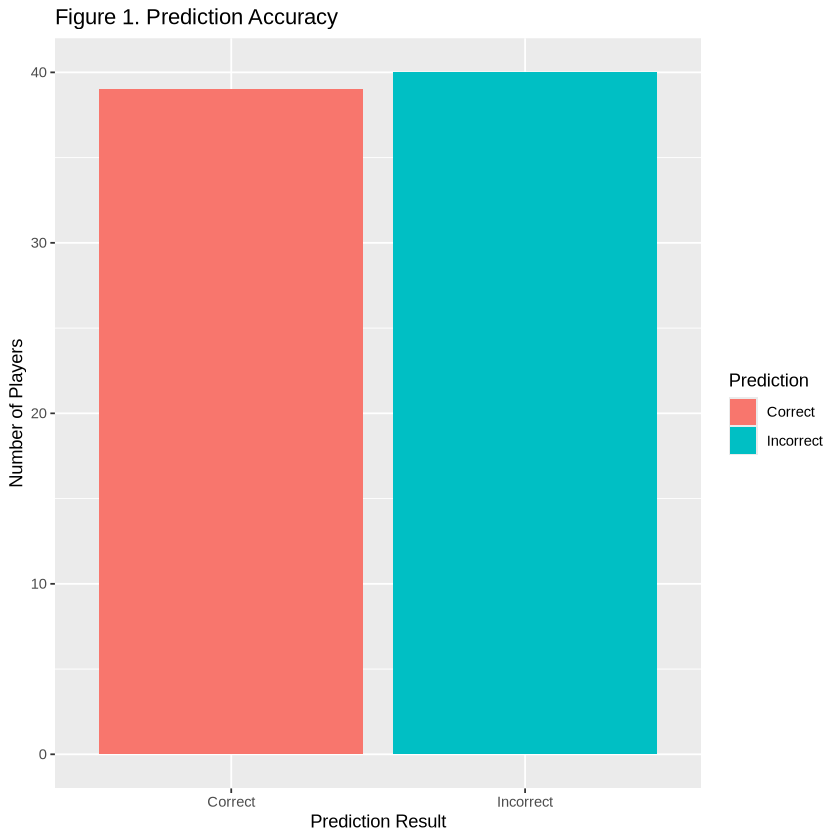

In [84]:
players_predictions |>
  ggplot(aes(x = correct, fill = correct)) +
  geom_bar() +
  labs(title = "Figure 1. Prediction Accuracy",
       x = "Prediction Result",
       y = "Number of Players",
       fill = "Prediction") 

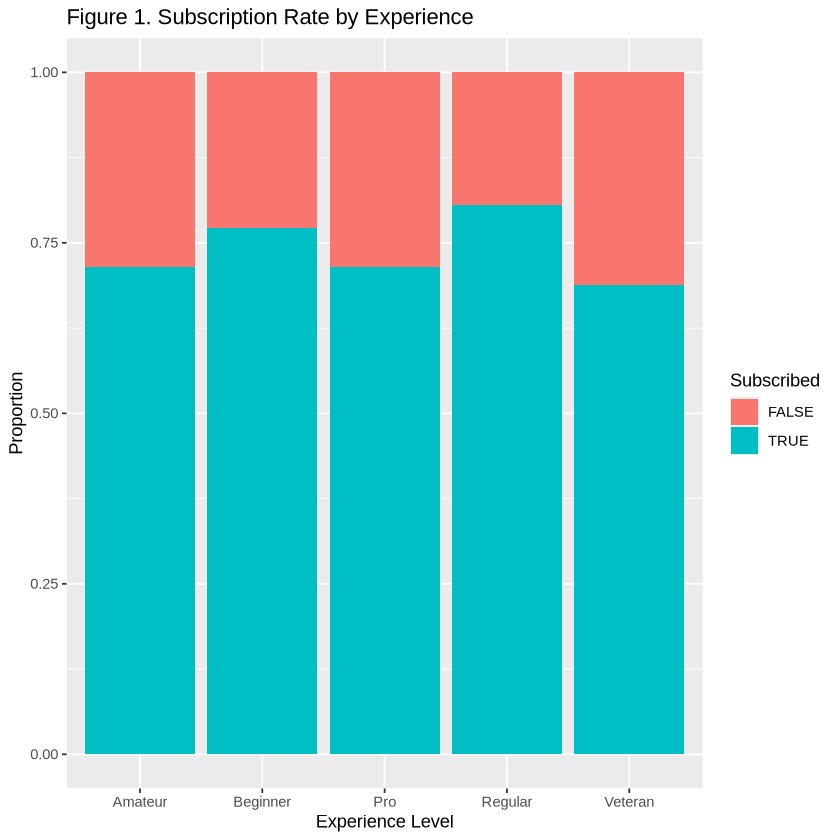

In [85]:
experience_plot <- ggplot(clean_players, aes(x = experience, fill = subscribe)) +
  geom_bar(position = "fill") +
  labs(title = "Figure 1. Subscription Rate by Experience",
    x = "Experience Level",
    y = "Proportion",
    fill = "Subscribed" )
experience_plot

In [86]:
played_hours_avg <- clean_players |>
  group_by(subscribe) |>
  summarize(mean_hours = mean(played_hours, na.rm = TRUE))

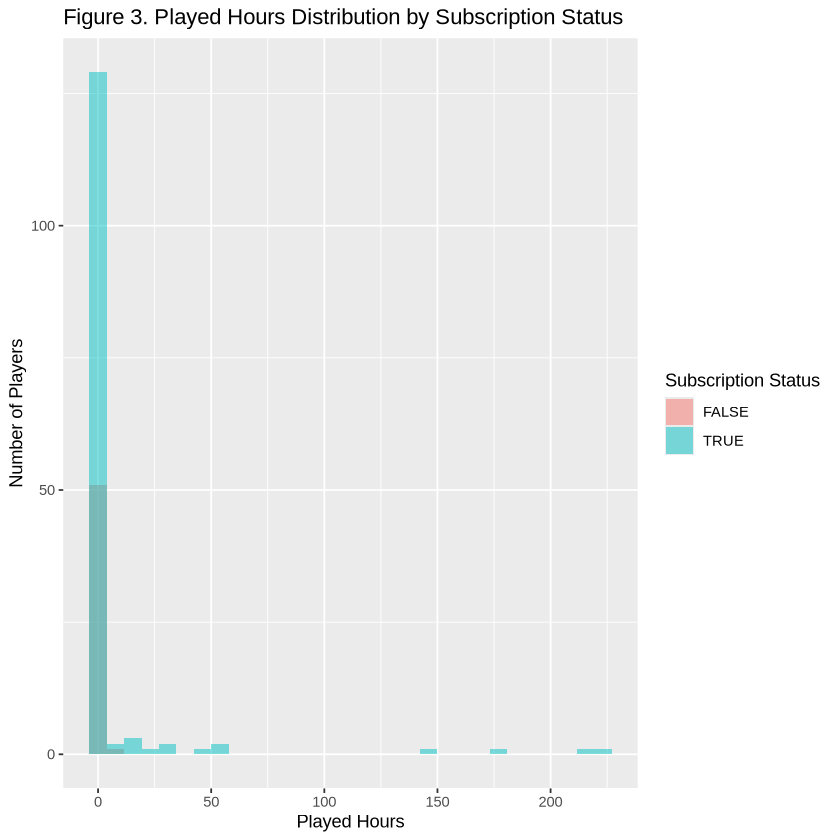

In [90]:
played_hours_plot <- ggplot(clean_players, aes(x = played_hours, fill = subscribe)) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 30) +
  labs(title = "Figure 3. Played Hours Distribution by Subscription Status",
       x = "Played Hours",
       y = "Number of Players",
       fill = "Subscription Status")
played_hours_plot